In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import itertools
import sklearn 
#sklearn.metrics.f1_score(lb.cpu().numpy(), pr.cpu().numpy(), labels=class_names)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Load Data Set


In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/Assignment 5 Dataset'

In [0]:
#!unzip "/content/drive/My Drive/Assignment 5 Dataset.zip" -d "/content/drive/My Drive"
#data_dir = '/content/drive/My Drive/Assignment 5 Dataset'

In [0]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([#transforms.RandomRotation(30),
                                       #transforms.RandomResizedCrop(224),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [7]:
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/test', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers = 2)
validloader = torch.utils.data.DataLoader(validation_data, batch_size=16, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)



Classes: 
['infected', 'normal']


In [8]:
len(train_data)

11837

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


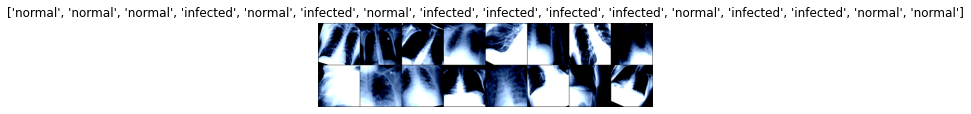

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(validloader))
show_databatch(inputs, classes)

## **Task 1**

#### Load pretrained models

In [0]:
# Load the pretrained model from pytorch

# Load VGG 16
#vgg16 = models.vgg16(pretrained=True)
vgg16 = models.vgg16(pretrained = False)
# Load ResNet16
#resnet = models.resnet18(pretrained= True)
resnet = models.resnet18(pretrained = False)


### Fine Tuning on VGG16

In [0]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(features)
print(num_features)

# Freeze training for all layers
for param in vgg16.features.parameters():
    param.requires_grad = False

[]
25088


In [0]:
# adding new features

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(num_features, 460 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),
     nn.Linear(460 ,len(class_names))])

vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# if already trained load pre trained model 
vgg16.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/vgg16_FC_Only.pth'))
vgg16.cuda() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Loss fucntion and optimizer
Epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

losses=[]
n = len(train_data)

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    prbar = tqdm(enumerate(trainloader))
    for i, data in prbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

      
        optimizer.zero_grad()
    
        outputs = vgg16(inputs)             #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()
        
        prbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    losses.append( running_loss/len(trainloader))    
    torch.save(vgg16.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_FC_Only.pth')

print('Finished Training')

Streaming output truncated to the last 5000 lines.

Train Epoch: 6 [1536/10717 (14%)]	Loss: 0.568033: : 12it [00:44,  3.35s/it]

Train Epoch: 6 [1536/10717 (14%)]	Loss: 0.568033: : 13it [00:44,  3.38s/it]

Train Epoch: 6 [1664/10717 (15%)]	Loss: 0.546229: : 13it [00:47,  3.38s/it]

Train Epoch: 6 [1664/10717 (15%)]	Loss: 0.546229: : 14it [00:47,  3.36s/it]

Train Epoch: 6 [1792/10717 (17%)]	Loss: 0.535160: : 14it [00:50,  3.36s/it]

Train Epoch: 6 [1792/10717 (17%)]	Loss: 0.535160: : 15it [00:50,  3.36s/it]

Train Epoch: 6 [1920/10717 (18%)]	Loss: 0.512525: : 15it [00:54,  3.36s/it]

Train Epoch: 6 [1920/10717 (18%)]	Loss: 0.512525: : 16it [00:54,  3.36s/it]

Train Epoch: 6 [2048/10717 (19%)]	Loss: 0.539853: : 16it [00:57,  3.36s/it]

Train Epoch: 6 [2048/10717 (19%)]	Loss: 0.539853: : 17it [00:57,  3.39s/it]

Train Epoch: 6 [2176/10717 (20%)]	Loss: 0.499754: : 17it [01:00,  3.39s/it]

Train Epoch: 6 [2176/10717 (20%)]	Loss: 0.499754: : 18it [01:00,  3.36s/it]

Train Epoch: 6 [2304/107

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses)

#### **Testing**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


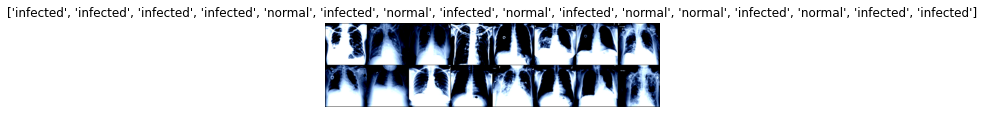

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

#### Accuracy

**Testing Accuracy**

In [0]:
def Accuracy(network ,dataset):
  correct = 0
  total = 0
  inx = 0 
  predlist=torch.zeros(0,dtype=torch.long, device='cuda')
  lbllist=torch.zeros(0,dtype=torch.long, device='cuda')
  with torch.no_grad():
    for data in dataset:

        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = network(images)
        _, predicted = torch.max(outputs.data, 1)

        predlist=torch.cat([predlist,predicted.view(-1)])
        lbllist=torch.cat([lbllist,labels.view(-1)])

        inx += 1
        print("\r Iterating on image batches : ",inx,end="")
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
  return (100*correct/total),predlist,lbllist

In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
def F1_Score(conf_mat):
  TP = conf_mat[0][0]
  FN = conf_mat[0][1]
  FP = conf_mat[1][0]
  TN = conf_mat[1][1]

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)
  F1Score = 2*((Precision*Recall)/(Precision+Recall))

  print("Precision:",Precision)
  print("Recall:",Recall)
  print("F1 Score",F1Score)

In [0]:
t_acc , pr, lb = Accuracy(vgg16,testloader)
print("\n Testing Accuracy %d %%" % t_acc)

 Iterating on image batches :  94
 Testing Accuracy 80 %


Confusion matrix, without normalization
[[454 161]
 [139 746]]


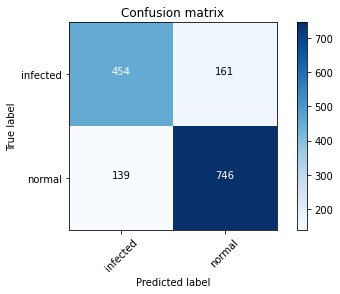

In [0]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

In [0]:
F1_Score(conf_mat)

Precision: 0.7655986509274874
Recall: 0.7382113821138211
F1 Score 0.7516556291390728


**Validation Accuracy & Confusion Matrix**

 Iterating on image batches :  94
Accuracy of the network on the Validation images: 63 %
Confusion matrix, without normalization
[[513 102]
 [445 440]]


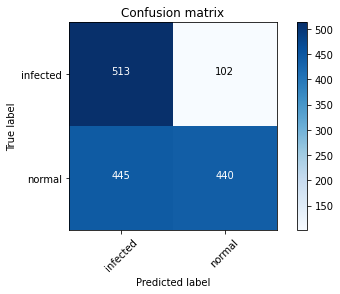

In [0]:
acc, pred, lbls = Accuracy(vgg16,validloader)
print('\nAccuracy of the network on the Validation images: %d %%' % acc)

# confusion matrix for testing 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

In [0]:
F1_Score(conf_mat)

Precision: 0.535490605427975
Recall: 0.8341463414634146
F1 Score 0.652256834075016


**Training Accuracy & Confusion Matrix**

In [0]:
acc, pred, lbls = Accuracy(vgg16,trainloader)
print('\n [ Training Accuracy ] : %d %%' % acc)

 Iterating on image batches :  86
 [ Training Accuracy ] : 83 %


Confusion matrix, without normalization
[[3818 1101]
 [ 734 5351]]


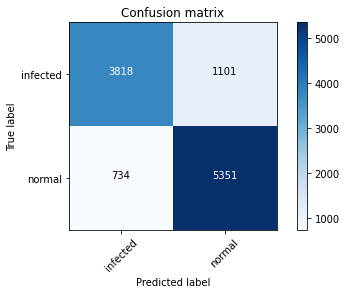

In [0]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

In [0]:
F1_Score(conf_mat)

Precision: 0.8387521968365553
Recall: 0.7761740191095751
F1 Score 0.8062506599091964


*Testing* 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  normal
Predicted:  infected


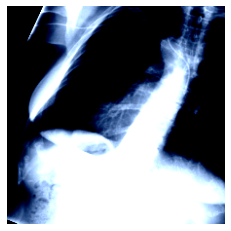

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected
Predicted:  infected


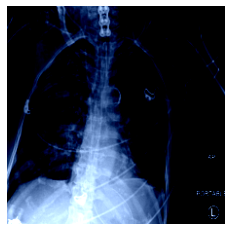

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

### Fine Tuning on Resnet

In [0]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
nfeatures = resnet.fc.in_features
features = list(resnet.fc.children())[:-1] #Remove last layer
print(features)

[]


In [0]:
# Freeze training for all layers
for param in resnet.parameters():
    param.requires_grad = False

In [0]:
# adding new features

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(nfeatures, 460 ),
     nn.ReLU(inplace=True),
     nn.Linear(460 ,len(class_names))])

In [0]:
resnet.fc = nn.Sequential(*features)
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training on Resnet

In [0]:
resnet.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/res18_FC_Only.pth'))
resnet.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Loss fucntion and optimizer
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet.to(device)

resnet.train()

n = len(train_data)
losses_r = []
acc_r = []
correct = 0

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
    
        outputs = resnet(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_r.append(100 * correct / n) 
    losses_r.append(running_loss/len(trainloader))
    correct = 0
    torch.save(resnet.state_dict(), '/content/drive/My Drive/Colab Notebooks/res18_FC_Only.pth')

print('Finished Training')

Train Epoch: 0 [10540/11004 (99%)]	Loss: 0.401073: : 86it [03:41,  2.57s/it]
Train Epoch: 1 [10540/11004 (99%)]	Loss: 0.328051: : 86it [03:31,  2.46s/it]
Train Epoch: 2 [10540/11004 (99%)]	Loss: 0.286315: : 86it [03:40,  2.56s/it]
Train Epoch: 3 [10540/11004 (99%)]	Loss: 0.263265: : 86it [03:42,  2.59s/it]
Train Epoch: 4 [10540/11004 (99%)]	Loss: 0.298422: : 86it [03:36,  2.52s/it]
Train Epoch: 5 [10540/11004 (99%)]	Loss: 0.250908: : 86it [03:36,  2.52s/it]
Train Epoch: 6 [10540/11004 (99%)]	Loss: 0.211801: : 86it [03:34,  2.49s/it]
Train Epoch: 7 [10540/11004 (99%)]	Loss: 0.344660: : 86it [03:34,  2.50s/it]
Train Epoch: 8 [10540/11004 (99%)]	Loss: 0.228438: : 86it [03:41,  2.57s/it]
Train Epoch: 9 [10540/11004 (99%)]	Loss: 0.275449: : 86it [03:39,  2.55s/it]
Train Epoch: 10 [10540/11004 (99%)]	Loss: 0.336248: : 86it [03:33,  2.48s/it]
Train Epoch: 11 [10540/11004 (99%)]	Loss: 0.293611: : 86it [03:26,  2.41s/it]
Train Epoch: 12 [10540/11004 (99%)]	Loss: 0.249017: : 86it [03:28,  2.43s/

Finished Training


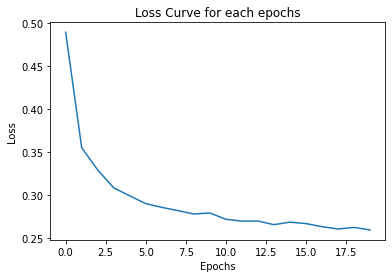

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses_r)

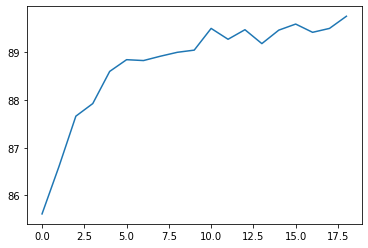

In [0]:
plt.plot(acc)

#### Testing [Resnet]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  normal normal infected normal
Predicted:  normal infected infected normal


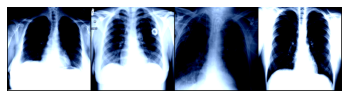

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:4],labels[:4]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

#### Accuracy (of model trained on ResNet)

**Training Accuracy and Confusion Matrix**

In [0]:
acc, pred, lbls = Accuracy(resnet,trainloader)
print('\n [ Training Accuracy ] : %d %%' % acc)

 Iterating on image batches :  86
 [ Training Accuracy ] : 89 %


Confusion matrix, without normalization
[[4242  677]
 [ 434 5651]]


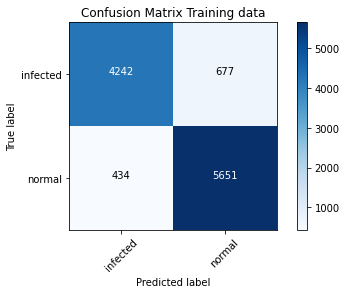

In [0]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Training data")

In [0]:
F1_Score(conf_mat)

Precision: 0.907185628742515
Recall: 0.862370400487904
F1 Score 0.8842105263157894


**Testing Accuracy and Confusion Matrix**

In [0]:
ac, p, lb = Accuracy(resnet,testloader)
print('\n [ Testing Accuracy ] : %d %%' % ac)

 Iterating on image batches :  94
 [ Testing Accuracy ] : 85 %


Confusion matrix, without normalization
[[506 109]
 [110 775]]


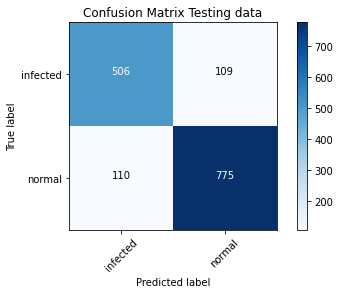

In [0]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), p.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Testing data")

In [0]:
F1_Score(conf_mat)

Precision: 0.8214285714285714
Recall: 0.8227642276422764
F1 Score 0.8220958570268074


**Validation Accuracy and Confusion Matrix**

In [0]:
ac, pr, lb = Accuracy(resnet,validloader)
print('\n [ Validation Accuracy ] : %d %%' % ac)

 Iterating on image batches :  94
 [ Validation Accuracy ] : 79 %


Confusion matrix, without normalization
[[483 132]
 [179 706]]


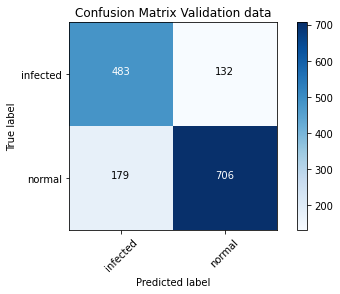

In [0]:
# confusion matrix for validation data 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Validation data")

In [0]:
F1_Score(conf_mat)

Precision: 0.729607250755287
Recall: 0.7853658536585366
F1 Score 0.7564604541895066


*Testing Resnet*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected
Predicted:  normal


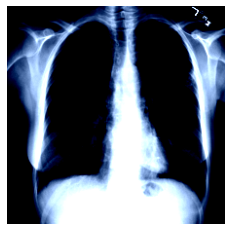

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:1],labels[:1]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

_____________________________________________________________________________

## **Task 2** 

For task 2 we are again loading pretrained model of VGG 16 and Resnet 18

In [14]:
# Load the pretrained model from pytorch

# Load VGG 16
VGG = models.vgg16(pretrained=True)
# Load ResNet16
RESNET = models.resnet18(pretrained= True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


## Test1 Freezing All Conv. layers except few (VGG16)


In [0]:
#print(VGG)

#### Freezing all the layers except last 5 conv. layers

In [0]:
# Freeze training for all layers except last 5
for param in VGG.features[:25].parameters():
    param.requires_grad = False

In [16]:
num_features = VGG.classifier[0].in_features

# update FC Layer new features
features = list(VGG.classifier.children())[:-7] 
print(features)
print(num_features)

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(num_features, 460 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),
     nn.Linear(460 ,len(class_names))])

[]
25088


In [17]:
VGG.classifier = nn.Sequential(*features)
print(VGG)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# if already trained load pre trained model 
VGG.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/vgg16_Few_Only_1.pth'))
VGG.cuda() 

#### Training on VGG16

In [0]:
# Loss fucntion and optimizer
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG.parameters(), lr=0.001, momentum=0.9)

In [23]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG.to(device)  
VGG.train()

n = len(train_data)
loss_VGG = []
acc_VGG = []
correct = 0

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
    
        outputs = VGG(inputs)            #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
     
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_VGG.append(correct / n) 
    loss_VGG.append(running_loss/len(trainloader))
    correct = 0    
    torch.save(VGG.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_Few_Only_1.pth')

print('Finished Training')

Train Epoch: 0 [5612/11837 (99%)]	Loss: 0.207562: : 93it [31:12, 20.13s/it]
Train Epoch: 1 [5612/11837 (99%)]	Loss: 0.140926: : 93it [03:11,  2.06s/it]
Train Epoch: 2 [5612/11837 (99%)]	Loss: 0.047973: : 93it [03:05,  1.99s/it]
Train Epoch: 3 [5612/11837 (99%)]	Loss: 0.131548: : 93it [03:04,  1.98s/it]
Train Epoch: 4 [5612/11837 (99%)]	Loss: 0.030297: : 93it [03:04,  1.98s/it]
Train Epoch: 5 [5612/11837 (99%)]	Loss: 0.109279: : 93it [03:02,  1.96s/it]
Train Epoch: 6 [5612/11837 (99%)]	Loss: 0.126535: : 93it [03:01,  1.95s/it]
Train Epoch: 7 [5612/11837 (99%)]	Loss: 0.032904: : 93it [03:01,  1.95s/it]
Train Epoch: 8 [5612/11837 (99%)]	Loss: 0.029882: : 93it [03:01,  1.95s/it]
Train Epoch: 9 [5612/11837 (99%)]	Loss: 0.013587: : 93it [03:01,  1.95s/it]
Train Epoch: 10 [5612/11837 (99%)]	Loss: 0.025526: : 93it [02:58,  1.92s/it]
Train Epoch: 11 [5612/11837 (99%)]	Loss: 0.029662: : 93it [02:59,  1.93s/it]
Train Epoch: 12 [5612/11837 (99%)]	Loss: 0.003615: : 93it [03:04,  1.98s/it]
Train Epo

Finished Training


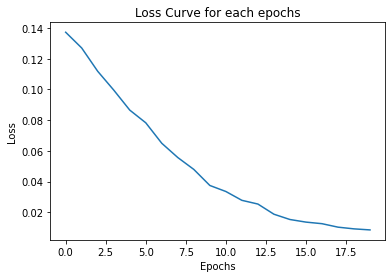

In [24]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_VGG)

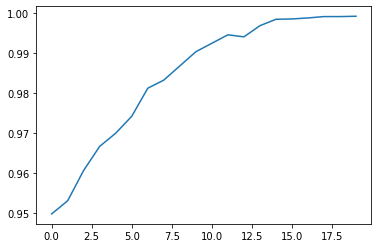

In [25]:
plt.plot(acc_VGG)

#### Accuracy

**Training Accuracy**

In [26]:
ac, pred, lbls = Accuracy(VGG,trainloader)
print('\n [ Training Accuracy ] : %d %%' % ac)

 Iterating on image batches :  93
 [ Training Accuracy ] : 99 %


Confusion matrix, without normalization
[[4919    0]
 [   1 6917]]


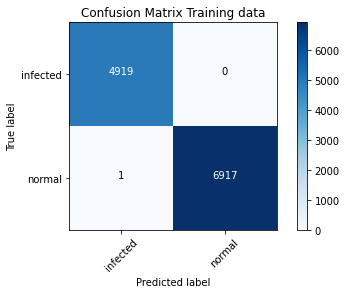

In [27]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Training data")

In [28]:
F1_Score(conf_mat)

Precision: 0.9997967479674796
Recall: 1.0
F1 Score 0.999898363654843


**Testing Accuracy**

In [29]:
ac, pr, lb = Accuracy(VGG,testloader)
print('\n [ Testing Accuracy ] : %d %%' % ac)

 Iterating on image batches :  94
 [ Testing Accuracy ] : 89 %


Confusion matrix, without normalization
[[545  70]
 [ 88 797]]


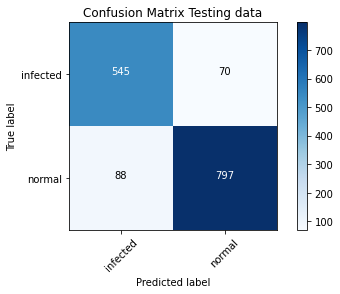

In [30]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Testing data")

In [31]:
F1_Score(conf_mat)

Precision: 0.8609794628751974
Recall: 0.8861788617886179
F1 Score 0.8733974358974359


**Validation Accuracy**

In [32]:
ac, pr, lb = Accuracy(VGG,validloader)
print('\n [ Validation Accuracy ] : %d %%' % ac)


 Iterating on image batches :  94
 [ Validation Accuracy ] : 61 %


Confusion matrix, without normalization
[[604  11]
 [574 311]]


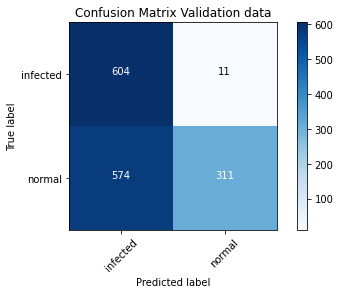

In [33]:
# confusion matrix for validation 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Validation data")

In [34]:
F1_Score(conf_mat)

Precision: 0.5127334465195246
Recall: 0.9821138211382113
F1 Score 0.6737311767986613


## Test2 Unfreeze all layers (VGG16)



In [35]:
VGG = models.vgg16(pretrained=False)
print('Output Layer of VGG16 : ', VGG.classifier[6].out_features) # 1000 
print(VGG.classifier[3])

Output Layer of VGG16 :  1000
Linear(in_features=4096, out_features=4096, bias=True)


 #### Unfreeze all the layers

In [36]:
num_features = VGG.classifier[0].in_features
features = list(VGG.classifier.children())[:-7] # Remove last layer
print(features)
print(num_features)

# This part is not optional
# Freeze training for all layers
for param in VGG.features.parameters():
    param.requires_grad = True

[]
25088


Remove all FC layers and add new one

In [0]:
# adding new features

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(num_features, 460 ),
     nn.ReLU(inplace=True),
     nn.Dropout(p=0.5,inplace=False),
     nn.Linear(460 ,len(class_names))])

In [38]:
VGG.classifier = nn.Sequential(*features)
print(VGG)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Load pre trained model

In [39]:
# if you have already trained model then use this to load
VGG.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/vgg16_entire.pth'))
VGG.cuda() 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Loss fucntion and optimizer
Epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG.parameters(), lr=0.001, momentum=0.9)

#### Training on VGG 16

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
VGG.to(device)

VGG.train()

losses=[]
acc_VGG = []
n = len(train_data)
correct = 0

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

      
        optimizer.zero_grad()
    
        outputs = VGG(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_VGG.append(correct / n)    
    losses.append(running_loss/len(trainloader))   
    correct = 0 
    torch.save(VGG.state_dict(), '/content/drive/My Drive/Colab Notebooks/vgg16_entire.pth')

print('Finished Training')

Train Epoch: 0 [9472/11837 (80%)]	Loss: 0.008627: : 75it [02:55,  2.47s/it]

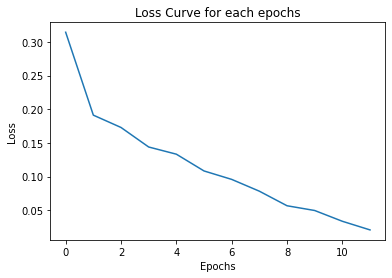

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses)

#### Accuracy

**Testing Accuracy**

In [0]:
t_acc , pr, lb = Accuracy(VGG,testloader)
print("\n Testing Accuracy %d %%" % t_acc)

 Iterating on image batches :  94
 Testing Accuracy 91 %


Confusion matrix, without normalization
[[546  69]
 [ 64 821]]


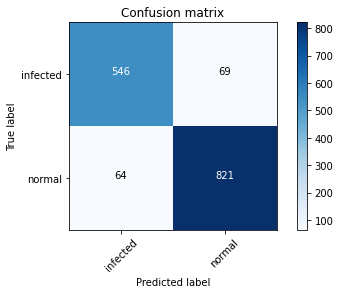

In [0]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

**Validdation Accuracy**

In [0]:
acc, pred, lbls = Accuracy(VGG,validloader)
print('\nAccuracy of the network on the Validation images: %d %%' % acc)

 Iterating on image batches :  94
Accuracy of the network on the Validation images: 64 %


Confusion matrix, without normalization
[[601  14]
 [513 372]]


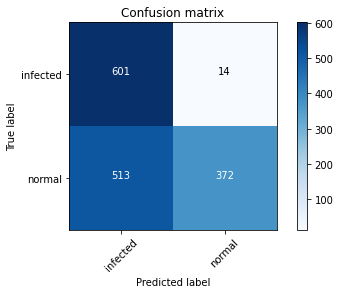

In [0]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

**Training Accuracy**

In [0]:
acc, pred, lbls = Accuracy(VGG,trainloader)
print('\n [ Training Accuracy ] : %d %%' % acc)

 Iterating on image batches :  81
 [ Training Accuracy ] : 99 %


Confusion matrix, without normalization
[[4585   35]
 [   2 5661]]


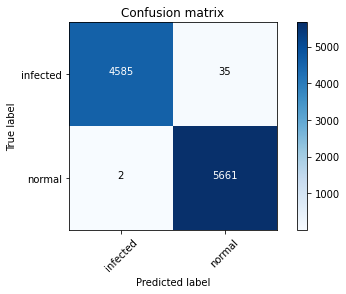

In [0]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names)

**Testing**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected normal
Predicted:  infected infected


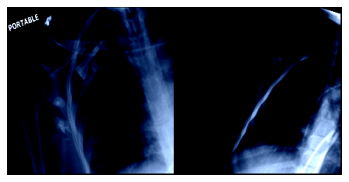

In [0]:
dataiter = iter(validloader)
images, labels = dataiter.next()
images,labels = images[:2],labels[:2]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = VGG(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected normal
Predicted:  infected infected


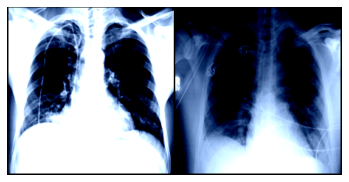

In [0]:
dataiter = iter(tesloader)
images, labels = dataiter.next()

images,labels = images[:2],labels[:2]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = VGG(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

## (Resnet18) Test 2- Unfreeze all layers

#### Unfreeze all layers

In [0]:
RESNET = models.resnet18(pretrained= False)  #load model class
nfeatures = RESNET.fc.in_features
features = list(RESNET.fc.children())[:-1] #Remove last layer
print(features)

[]


In [0]:
for param in RESNET.parameters():
    param.requires_grad = True

# adding new features

#(Last 2 digits of your roll number x 10) + 100  = (36X10)+100 = 460
features.extend(
    [nn.Linear(nfeatures, 460 ),
     nn.ReLU(inplace=True),
     nn.Linear(460 ,len(class_names))])

In [0]:
RESNET.fc = nn.Sequential(*features)
print(RESNET)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
#If you have pre trained model then use this to load
RESNET.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/res18_entire.pth'))
RESNET.cuda()

#### Training on Resnet

In [0]:
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESNET.to(device)

RESNET.train()

n = len(train_data)
losses_r = []
acc_r = []
correct = 0

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
    
        outputs = RESNET(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

      
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum().item()

        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))

    acc_r.append(100 * correct / n) 
    losses_r.append(running_loss/len(trainloader))
        
    torch.save(RESNET.state_dict(), '/content/drive/My Drive/Colab Notebooks/res18_entire.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/10283 (0%)]	Loss: 0.682311: : 0it [00:03, ?it/s]
Train Epoch: 0 [0/10283 (0%)]	Loss: 0.682311: : 1it [00:03,  3.75s/it]
Train Epoch: 0 [128/10283 (1%)]	Loss: 0.664548: : 1it [00:07,  3.75s/it]
Train Epoch: 0 [128/10283 (1%)]	Loss: 0.664548: : 2it [00:07,  3.79s/it]
Train Epoch: 0 [256/10283 (2%)]	Loss: 0.676973: : 2it [00:11,  3.79s/it]
Train Epoch: 0 [256/10283 (2%)]	Loss: 0.676973: : 3it [00:11,  3.79s/it]
Train Epoch: 0 [384/10283 (4%)]	Loss: 0.673654: : 3it [00:15,  3.79s/it]
Train Epoch: 0 [384/10283 (4%)]	Loss: 0.673654: : 4it [00:15,  3.78s/it]
Train Epoch: 0 [512/10283 (5%)]	Loss: 0.661834: : 4it [00:18,  3.78s/it]
Train Epoch: 0 [512/10283 (5%)]	Loss: 0.661834: : 5it [00:18,  3.76s/it]
Train Epoch: 0 [640/10283 (6%)]	Loss: 0.646795: : 5it [00:22,  3.76s/it]
Train Epoch: 0 [640/10283 (6%)]	Loss: 0.646795: : 6it [00:22,  3.83s/it]
Train Epoch: 0 [768/10283 (7%)]	Loss: 0.645344: : 6it [00:26,  3.83s/it]
Train Epoch: 0 [768/10283 (7%)]	Loss: 0

Finished Training


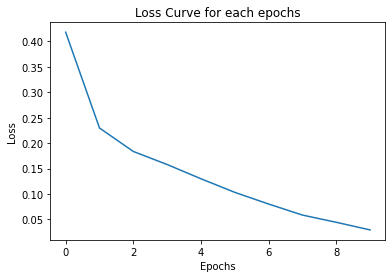

In [0]:
plt.title("Loss Curve for each epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(losses_r)

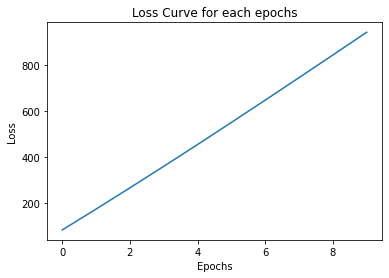

In [0]:
plt.title("Accuracy for each epochs")
plt.plot(acc_r)

#### Accuracy

**Training Accuracy**

In [0]:
acc, pred, lbls = Accuracy(RESNET,trainloader)
print('\n [ Training Accuracy ] : %d %%' % acc)

 Iterating on image batches :  145
 [ Training Accuracy ] : 91 %


Confusion matrix, without normalization
[[3560  519]
 [ 271 4929]]


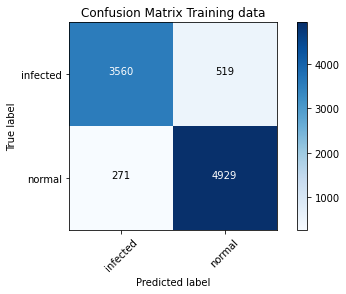

In [0]:
# confusion matrix for training 
conf_mat=confusion_matrix(lbls.cpu().numpy(), pred.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Training data")

**Testing Accuracy**

In [0]:
ac, p, lb = Accuracy(RESNET,testloader)
print('\n [ Testing Accuracy ] : %d %%' % ac)

 Iterating on image batches :  94
 [ Testing Accuracy ] : 87 %


Confusion matrix, without normalization
[[511 104]
 [ 97 788]]


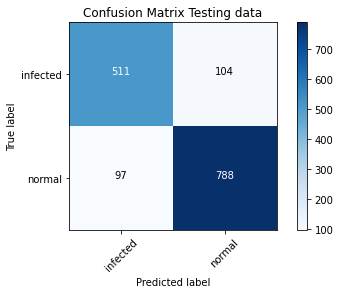

In [0]:
# confusion matrix for testing 
conf_mat=confusion_matrix(lb.cpu().numpy(), p.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Testing data")

**Validation Accuracy**

In [0]:
ac, pr, lb = Accuracy(RESNET,validloader)
print('\n [ Validation Accuracy ] : %d %%' % ac)


 [ Validation Accuracy ] : 81 %


Confusion matrix, without normalization
[[510 105]
 [176 709]]


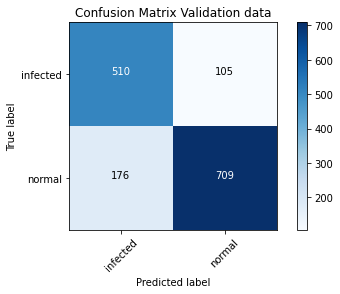

In [0]:
# confusion matrix for validation data 
conf_mat=confusion_matrix(lb.cpu().numpy(), pr.cpu().numpy())
plot_confusion_matrix(conf_mat,class_names,title="Confusion Matrix Validation data")

*Model Testing*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  normal infected
Predicted:  normal infected


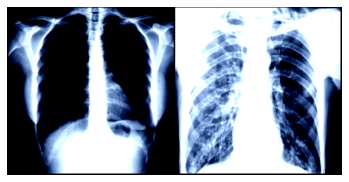

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:2],labels[:2]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = RESNET(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  infected normal infected normal
Predicted:  infected normal infected normal


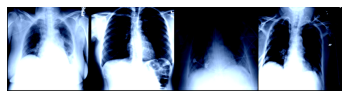

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

images,labels = images[:4],labels[:4]
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(len(images))))

images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = RESNET(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))